### Capstone: Using Multiclass Classification Models to Predict the Bus Arrival Status to Stop 


#### Import and Setup

In [1]:
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
import time

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_auc_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PipelineImb 

warnings.simplefilter(action='ignore')

In [3]:
# SMOTE and ADASYN require the imblearn library, uncomment next line to install it.
#!pip install imbalanced-learn

### Business Understanding ### 
The Public Transportation Companies deal daily with the challenge to ensure their buses be on time in every Stop so passengers can reach their destinations on time too. Sometimes, some factors like the traffic, weather and peak hours avoid meet that goal. 

**Research question**

Can the Public Transportation Bus Arrival to Stop be predicted as On Time, Early Or Late?

**Why this question is important?**

Be able to predict the Stop Bus Arrival Status with high accuracy will be very helpful to the users who can plan better their trips. For companies this can be very benefitial so they provide this status in the several platform and services they offer to users:
   - App-Based Tracking: Provide real-time bus arrival information, like the Miami-Dade Transit app
   - Digital Displays at Stops: Some bus stops have digital displays that show expected arrival information.
   - Text-Based Alerts: Some transit authorities offer text message alerts that notify users of bus arrival information.


### Data
The data comes from the Public Trasportation History database that the company I work for has developed for a Public Transportation Company. The database is updated daily with the information about:
- City bus routes.
- City bus stops.
- Buses.
- For every bus, a 15 minutes frequency was defined to visit each stop of the assigned route.
- For every stop and bus, a record is stored containing all the data when a Bus arrived and left each stop.

For the scope of this capstone, I extracted the bus arrival to stop data filtering a single Stop and a date range of 3 months(April-2024 to June-2024).


In [183]:
pt_bus_stop_df = pd.read_csv("data/pt_bus_stop.csv")

In [185]:
print(pt_bus_stop_df.shape)
pt_bus_stop_df.head()

(3939, 22)


ID   UnitID  StopID  StopNumber               DateIN  \
0  72475793  1072464  920789          49  2024-04-01 07:01:04   
1  72476645  1088158  920789          49  2024-04-01 07:31:31   
2  72477913  1072464  920789          49  2024-04-01 08:20:10   
3  72480029  1072464  920789          49  2024-04-01 09:27:45   
4  72481491  1088158  920789          49  2024-04-01 10:01:15   

               DateOUT WeekDay PrevWeekDay PeakHour  StopDuration  ...  \
0  2024-04-01 07:01:04  Monday         NaN      Yes             0  ...   
1  2024-04-01 07:32:11  Monday      Monday      Yes            40  ...   
2  2024-04-01 08:20:10  Monday      Monday      Yes             0  ...   
3  2024-04-01 09:27:45  Monday      Monday       No             0  ...   
4  2024-04-01 10:01:45  Monday      Monday       No            30  ...   

  TripDuration  Odometer  PrevStopOdometer  PrevStopNumber  DistanceLastStop  \
0            0  34175.43               NaN             NaN            756.42   
1            0  42729.68               NaN             NaN            166.79   
2         4746  34183.02          34175.43            49.0           1390.33   
3         4055  34190.70          34183.02            49.0           1390.33   
4         8944  42737.22          42729.68            49.0            166.79   

   Speed  OTPMode  OnTimeStatus  TripDistance  TripSpeedAvg  
0      0        2             1           NaN           NaN  
1     16        2             3           NaN           NaN  
2      0        2             3          7.59      0.001599  
3      0        2             3          7.68      0.001894  
4      0        2             3          7.54      0.000843  

[5 rows x 22 columns]

### Dataset Description 

#### The dataset contains the next featues:
- ID: record unique ID
- UnitID: Unique ID assigned to the Bus unit.
- StopID: Unique ID assigned to a Bus Stop.
- StopNumber: Friendly name assigned to Stop, this is defined by the Bus Company to name each Route Stop.
- DateIN: Date time when the Bus has arrived to the Stop.
- DateOUT: Date time when Bus has left the Stop.
- WeekDay: Day name of the arrival date time.
- PrevWeekDay: Day name of the previous arrival date time.
- PeakHour: Flag to mark as Yes/No if the traffic is at its worst between 7 a.m. and 9 a.m. and 4 p.m. and 7 p.m.
- StopDuration: time spent by the bus within the Stop.
- PrevDateIn: Date time when the previous bus arrived to the current stop.
- DifferencePrevBusIn: Time difference between PrevDateIn and DateIN.
- TripDuration: Time spent by the bus to complete a trip.
- Odometer: Bus odometer when it arrived to stop at DateIn.
- PrevStopOdometer: Bus odometer when it arrived to stop at PrevDateIn.
- PrevStopNumber: Previous stop.
- DistanceLastStop: Distance between the last stop visited and the current stop.
- Speed: Bus speed when it arrived to stop.
- OTPMode: Mode of calculation of the Stop status: 2 means Headway.
- OnTimeStatus: Status assigned to the bus arrival (1=OnTime, 2=Early, 2=Late). This status is assigned according to Route Bus Frequency. Each 15 minutes a bus is expected to arrive to each stop.
- TripDistance: Distance of the trip.
- TripSpeedAvg: Bus speed average within the trip.

### Exploratory Data Analysis

#### Helper functions

In [15]:
def get_feature_unique_values(values_df, only_string):
    colList = values_df.dtypes.reset_index()
    # get the features with object type
    cols = colList
    if(only_string):
        cols = colList[colList[0] == 'object']
        
    col_unique_val_counter = []
    for colname in cols["index"]:
        col_unique_vals = values_df[colname].unique()
        print("--------------")
        print(colname, ", total unique values: ", len(col_unique_vals))
        print("--------------")    
        print(col_unique_vals)
        col_unique_val_counter.append([colname, len(col_unique_vals)])

    # show a sorted df with the unique values counting
    print(" ")
    print("----------------------------------------")
    print("--------Unique Values Summary-----------")
    print(pd.DataFrame(col_unique_val_counter, columns =["Feature", "Total"]).sort_values(by='Total', ascending=False))

In [17]:
def show_dataset_distribution():    
    fig = sns.catplot(x = 'OnTimeStatus', kind = 'count', data = pt_bus_stop_df)
    fig.fig.suptitle("Status Distribution")
    for fig in fig.axes.flat:
        fig.bar_label(fig.containers[0])
    fig.set_xticklabels(['OnTime','Early','Late'])
    plt.xlabel('Bus Arrival Status')
    plt.ylabel('Count of Stop Arrivals')
    plt.show()

In [19]:
#pt_bus_stop_df["OnTimeStatus"].value_counts()

In [21]:
pt_bus_stop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3939 entries, 0 to 3938
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   3939 non-null   int64  
 1   UnitID               3939 non-null   int64  
 2   StopID               3939 non-null   int64  
 3   StopNumber           3939 non-null   int64  
 4   DateIN               3939 non-null   object 
 5   DateOUT              3939 non-null   object 
 6   WeekDay              3939 non-null   object 
 7   PrevWeekDay          3938 non-null   object 
 8   PeakHour             3939 non-null   object 
 9   StopDuration         3939 non-null   int64  
 10  PrevDateIn           3938 non-null   object 
 11  DifferencePrevBusIn  3939 non-null   float64
 12  TripDuration         3939 non-null   int64  
 13  Odometer             3939 non-null   float64
 14  PrevStopOdometer     3896 non-null   float64
 15  PrevStopNumber       3896 non-null   f

In [23]:
#Review the null values
pt_bus_stop_df.isna().sum()

ID                      0
UnitID                  0
StopID                  0
StopNumber              0
DateIN                  0
DateOUT                 0
WeekDay                 0
PrevWeekDay             1
PeakHour                0
StopDuration            0
PrevDateIn              1
DifferencePrevBusIn     0
TripDuration            0
Odometer                0
PrevStopOdometer       43
PrevStopNumber         43
DistanceLastStop        0
Speed                   0
OTPMode                 0
OnTimeStatus            0
TripDistance           43
TripSpeedAvg           43
dtype: int64

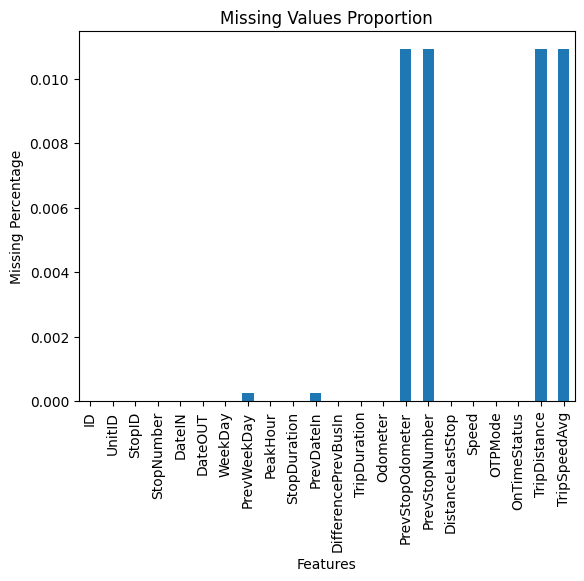

In [25]:
(pt_bus_stop_df.isna().sum() / len(pt_bus_stop_df)).plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Missing Percentage')
plt.title('Missing Values Proportion')
plt.show()

There are few records having missing values so we can delete them without impact on the distribution of dataset.

**Data Distribution**

The dataset is imbalanced, the Ontime and Late are quite balanced but Early has much less records than those statuses. This tell us we need to use a oversampling techique to help with the prediction.


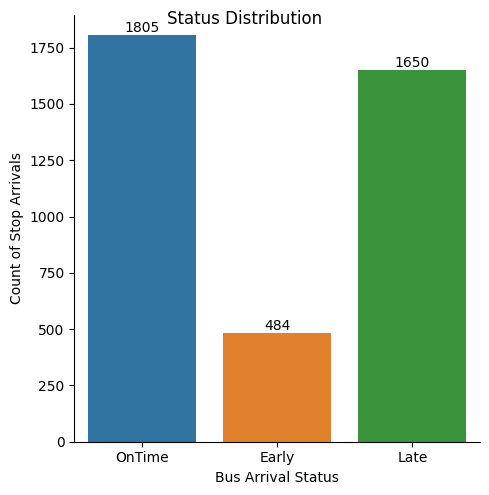

In [29]:
#Checking Status distribution 
show_dataset_distribution()

#### Data Cleaning and Features Engineering

In [192]:
# Removing the missing values, they're less than 1% of the data.
pt_bus_stop_df.dropna(inplace=True)

In [194]:
# Update the Data type for string features which contain numeric values
convert_dict = {'StopDuration': int, 
                'TripDuration': int, 
                'DistanceLastStop': float, 
                'TripDistance': float,
                'TripSpeedAvg': float
                }
pt_bus_stop_df = pt_bus_stop_df.astype(convert_dict)
pt_bus_stop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3896 entries, 2 to 3938
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   3896 non-null   int64  
 1   UnitID               3896 non-null   int64  
 2   StopID               3896 non-null   int64  
 3   StopNumber           3896 non-null   int64  
 4   DateIN               3896 non-null   object 
 5   DateOUT              3896 non-null   object 
 6   WeekDay              3896 non-null   object 
 7   PrevWeekDay          3896 non-null   object 
 8   PeakHour             3896 non-null   object 
 9   StopDuration         3896 non-null   int64  
 10  PrevDateIn           3896 non-null   object 
 11  DifferencePrevBusIn  3896 non-null   float64
 12  TripDuration         3896 non-null   int64  
 13  Odometer             3896 non-null   float64
 14  PrevStopOdometer     3896 non-null   float64
 15  PrevStopNumber       3896 non-null   float6

In [196]:
# Remove the features containing information about the stop, the bus identification this data is the same for all records  
pt_bus_stop_df.drop(["UnitID", "StopID", "StopNumber", "PrevStopNumber"], axis = 1, inplace = True)

# Remove the features containing information abour the date when the bus arrived and left the stop. For the analysis we're going the 
# duration within stop (DateOut - DateIn) and TripDuration
pt_bus_stop_df.drop(["DateIN", "DateOUT", "PrevDateIn"], axis = 1, inplace = True)

# Remove the PrevWeekDay feature, it's not needed for the analysis 
pt_bus_stop_df.drop(["PrevWeekDay"], axis = 1, inplace = True)

# Remove the OTPMode feature because it's the same for all records
pt_bus_stop_df.drop(["OTPMode"], axis = 1, inplace = True)

# Remove the DistanceLastStop and Speed because we're going to use  TripDistance and TripSpeedAvg intead
pt_bus_stop_df.drop(["DistanceLastStop", "Speed"], axis = 1, inplace = True)

pt_bus_stop_df.head()

ID WeekDay PeakHour  StopDuration  DifferencePrevBusIn  TripDuration  \
2  72477913  Monday      Yes             0               2919.0          4746   
3  72480029  Monday       No             0               4055.0          4055   
4  72481491  Monday       No            30               2010.0          8944   
5  72482859  Monday       No             0               2648.0          4658   
6  72483748  Monday       No            24               1654.0          4272   

   Odometer  PrevStopOdometer  OnTimeStatus  TripDistance  TripSpeedAvg  
2  34183.02          34175.43             3          7.59      0.001599  
3  34190.70          34183.02             3          7.68      0.001894  
4  42737.22          42729.68             3          7.54      0.000843  
5  34198.26          34190.70             3          7.56      0.001623  
6  42744.71          42737.22             3          7.49      0.001753

In [198]:
# Convert the SpeedAvg to Miles per hour
pt_bus_stop_df["TripSpeedAvg"] = pt_bus_stop_df["TripSpeedAvg"] * 3600
# Convert the TripDuration to hours
pt_bus_stop_df["TripDuration"] = pt_bus_stop_df["TripDuration"] / 3600
# Convert the StopDuration to hours
pt_bus_stop_df["StopDuration"] = pt_bus_stop_df["StopDuration"] / 3600
# Convert the DifferencePrevBusIn to hours
pt_bus_stop_df["DifferencePrevBusIn"] = pt_bus_stop_df["DifferencePrevBusIn"] / 3600


In [200]:
pt_bus_stop_df.head()

ID WeekDay PeakHour  StopDuration  DifferencePrevBusIn  TripDuration  \
2  72477913  Monday      Yes      0.000000             0.810833      1.318333   
3  72480029  Monday       No      0.000000             1.126389      1.126389   
4  72481491  Monday       No      0.008333             0.558333      2.484444   
5  72482859  Monday       No      0.000000             0.735556      1.293889   
6  72483748  Monday       No      0.006667             0.459444      1.186667   

   Odometer  PrevStopOdometer  OnTimeStatus  TripDistance  TripSpeedAvg  
2  34183.02          34175.43             3          7.59      5.757268  
3  34190.70          34183.02             3          7.68      6.818249  
4  42737.22          42729.68             3          7.54      3.034883  
5  34198.26          34190.70             3          7.56      5.842850  
6  42744.71          42737.22             3          7.49      6.311797

In [202]:
# Review the Outliers
# Trip duration must not exceed 90 minutes?
# TripDistance
# SpeedAvg
pt_bus_stop_df[["TripDuration", "DifferencePrevBusIn", "TripDistance", "TripSpeedAvg"]].describe()


TripDuration  DifferencePrevBusIn  TripDistance  TripSpeedAvg
count   3896.000000          3896.000000   3896.000000  3.896000e+03
mean       2.956544             0.544118     30.096604  6.370117e+04
std       22.276548             1.662732    252.703525  8.730905e+05
min       -0.001944           -31.613056   -140.570000 -3.270600e+05
25%        1.177222             0.220000      7.500000  5.777542e+00
50%        1.243889             0.305833      7.590000  6.111994e+00
75%        1.317500             0.511181      7.800000  6.475093e+00
max      826.217778            30.491944   9778.620000  3.520303e+07

In [204]:
# Remove negatives
columns_to_clean = ["TripDuration", "TripDistance", "TripSpeedAvg"]
pt_bus_stop_df[columns_to_clean] = pt_bus_stop_df[columns_to_clean].applymap(lambda x: np.nan if x < 0 else x)
pt_bus_stop_df.dropna(inplace=True)
# Remove Trip duration over 7200 secs (2 hours)
pt_bus_stop_df= pt_bus_stop_df[(pt_bus_stop_df["TripDuration"] > 0) & (pt_bus_stop_df["TripDuration"]<= 2)]
# Remove DifferencePrevBusIn over 7200 secs (2 hours)
pt_bus_stop_df= pt_bus_stop_df[(pt_bus_stop_df["DifferencePrevBusIn"] > 0) & (pt_bus_stop_df["DifferencePrevBusIn"]<= 2)]

# Remove Trip distance over length of route. The Bus Odomeeter could got spikes.
pt_bus_stop_df= pt_bus_stop_df[(pt_bus_stop_df["TripDistance"] > 0) & (pt_bus_stop_df["TripDistance"]<= 50)]

# Remove Trip Speed over 50. 
pt_bus_stop_df= pt_bus_stop_df[(pt_bus_stop_df["TripSpeedAvg"] > 0) & (pt_bus_stop_df["TripSpeedAvg"]< 50)]

pt_bus_stop_df[["TripDuration", "DifferencePrevBusIn", "TripDistance", "TripSpeedAvg"]].describe()

TripDuration  DifferencePrevBusIn  TripDistance  TripSpeedAvg
count   2975.000000          2975.000000   2975.000000   2975.000000
mean       1.237262             0.393299      7.646622      6.218081
std        0.125803             0.259771      1.654109      1.330951
min        0.004722             0.000556      0.010000      0.010292
25%        1.191389             0.222361      7.500000      5.854671
50%        1.241111             0.307222      7.570000      6.115489
75%        1.289583             0.503889      7.690000      6.422414
max        1.985000             1.662778     49.830000     34.962710

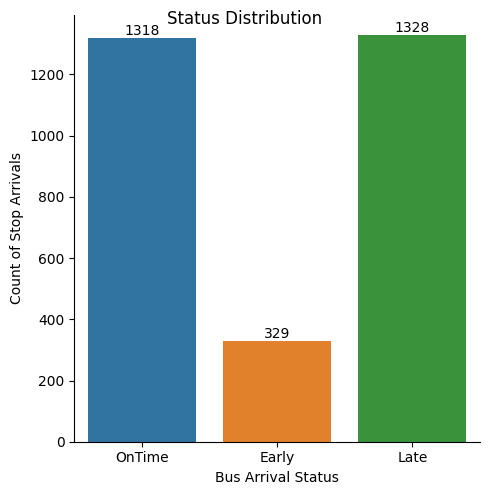

In [206]:
#Checking Status distribution after the cleaning and outliers removal.
show_dataset_distribution()

In [208]:
# Reviewing categorical features
# WeekDay contains the day name of the date when the bus visited the Stop, we're going replace its values 
# with 1 for weekdays and 0 for weekend
weekend = ['Saturday', 'Sunday']
pt_bus_stop_df["WeekDay"] = pt_bus_stop_df["WeekDay"].apply(lambda x: 0 if x in weekend else 1)
# PeakHour replacing its value with 1 ('Yes') and 0 ('No')
pt_bus_stop_df["PeakHour"].replace({"No" : 0, "Yes" : 1}, inplace = True)

In [210]:
# Renaming WeekedDay as IsWeekday
pt_bus_stop_df.rename({'WeekDay':'IsWeekday'}, axis=1, inplace=True)

#### Reviewing the correlation 

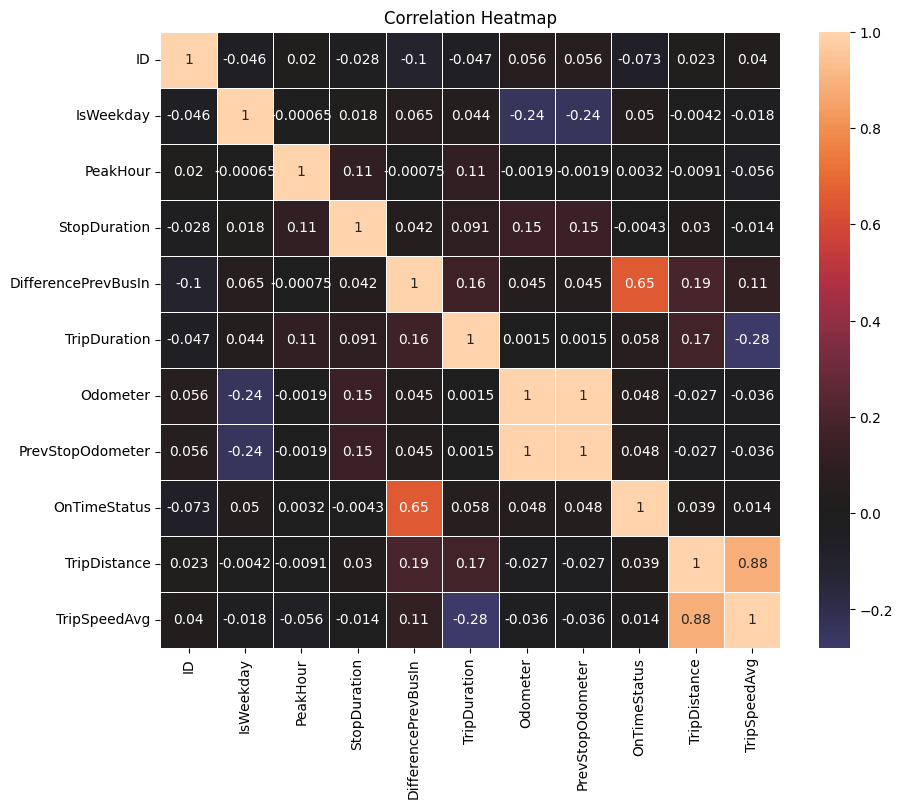

In [213]:
correlation_data = pt_bus_stop_df.corr()
#correlation heatmap  
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_data, center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');


The correlation show us there are several features with high correlation between them:
- Odometer and PrevStopOdometer: they were used to calculate the TripsDistance, so we can remove them.

  
Also the ID is a number used to identify each record, it's a big number so we can remove it too.

In [216]:
# Removing not needed features
pt_bus_stop_df.drop(["Odometer", "PrevStopOdometer", "ID" ], axis=1, inplace=True)

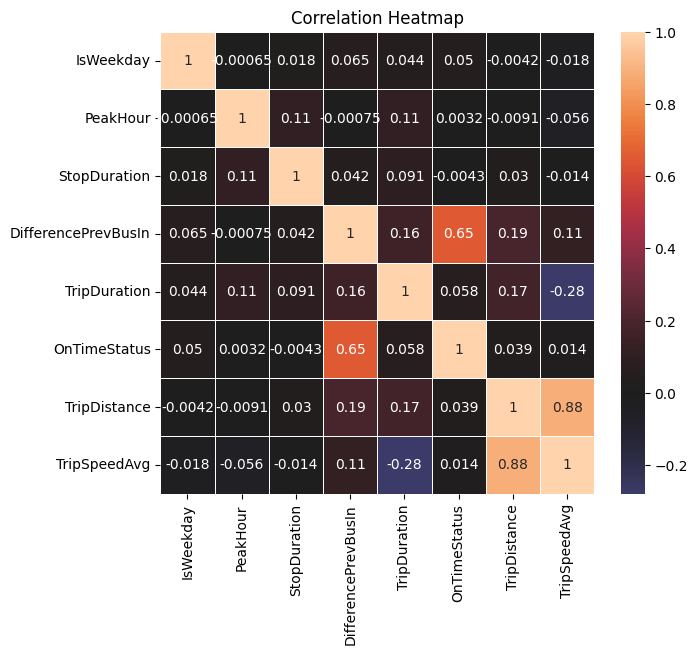

In [218]:
# Reviewing correlation again 
correlation_data = pt_bus_stop_df.corr()
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(correlation_data, center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');


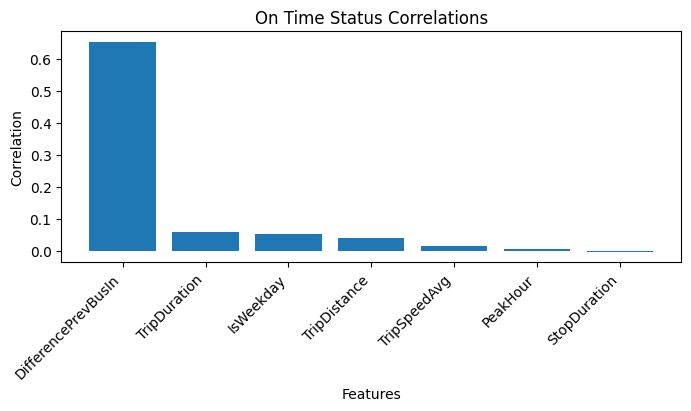

In [220]:
corr_df = correlation_data[['OnTimeStatus']].sort_values(by='OnTimeStatus', ascending=False)[1:].reset_index()
corr_df.rename(columns={"index": "feature"}, inplace=True)

plt.figure(figsize=(8,3))
plt.bar(x=corr_df["feature"], height=corr_df["OnTimeStatus"], label='line 1')
plt.title("On Time Status Correlations")
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

### Train/Test Split

In [223]:
#train test split
X = pt_bus_stop_df.drop("OnTimeStatus", axis=1)
y = pt_bus_stop_df['OnTimeStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [225]:
pt_bus_stop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2975 entries, 2 to 3938
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IsWeekday            2975 non-null   int64  
 1   PeakHour             2975 non-null   int64  
 2   StopDuration         2975 non-null   float64
 3   DifferencePrevBusIn  2975 non-null   float64
 4   TripDuration         2975 non-null   float64
 5   OnTimeStatus         2975 non-null   int64  
 6   TripDistance         2975 non-null   float64
 7   TripSpeedAvg         2975 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 209.2 KB


In [227]:
X_train.iloc[0]

IsWeekday              1.000000
PeakHour               0.000000
StopDuration           0.002500
DifferencePrevBusIn    0.128333
TripDuration           1.288611
TripDistance           7.840000
TripSpeedAvg           6.084068
Name: 1263, dtype: float64

### Model Training
- In the modeling stage we're going to use:
    - KNN
    - Decistion Tree
    - SVM
    - Logistic Regression
    - Random Forest
    - Gradient Boosting Classifier
    - AdaBoost Classifier
- For each classification algorithm we will use the cross validation using the Gridsearch and hyperparameters.
- With the aim to find the best model since the dataset is imbalanced we're going to use SMOTE tecnique for oversampling
- The macro-averaged F1 score is the most suitable measure for multiclass classification and imbalanced dataset.



#### Helper functions

In [231]:
def get_training_time_from_grid(grid):
    '''
    Get the Fit training time from the gridsearch.cv_results
    '''
    # get the mean fit time
    mean_fit_time= grid.cv_results_['mean_fit_time']
    #mean_score_time= search_cv.cv_results_['mean_score_time']
    #number of splits of training data
    n_splits  = grid.n_splits_ 
    #Iterations per split
    n_iter = pd.DataFrame(grid.cv_results_).shape[0] 
     #print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)
    return np.mean(mean_fit_time) * n_splits * n_iter  

In [233]:
result_list = []
def save_result(model, train_time, accuracy, best_params, f1, recall, precision):
    '''
    Save model results in a array
    '''
    result_list.append({
        'Model': model,
        'Train Time': train_time,
        'Accuracy': accuracy,
        'Best Params': best_params,
        'F1': f1, 
        'Recall': recall, 
        'Precision': precision
    })

In [270]:
def getConfusionMatrix(y_test, y_test_pred, display_labels):
    '''
    Get the confusion matrix for the provided data
    '''
    # confusion_mat = confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1), labels=[1, 2, 3])
    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=display_labels)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [237]:
def getScores(y_test, y_test_pred):
    '''
    Get the scores
    Because of dataset has a multiclass we need to use the average='macro', see next link:
    https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary
    '''    
    ps = precision_score(y_test, y_test_pred, average='macro')
    rc = recall_score(y_test, y_test_pred, average='macro')
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='macro')
    scores = pd.DataFrame({'Scores':['Precision', 'Recall', 'Accuracy', 'F1'], 'Values' : [ps, rc, acc, f1]})
    display(scores)
    sns.barplot(scores, x = 'Scores', y = 'Values')
    return (ps, rc, acc, f1)

In [239]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [241]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [243]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [256]:
from IPython.display import display, Markdown, Latex
def get_ovr_curve(X_test_in, y_test_in, estimator, predictions_in=[], class_values_in=[]):    
    '''
    # Plots the Probability Distributions and the ROC Curves One vs Rest    
    '''
    classes = [1,2,3]
    if len(class_values_in) > 0:
        classes = class_values_in
        
    class_labels = ['Ontime', 'Early', 'Late']   
    y_proba = predictions_in
    if len(y_proba) == 0:
        y_proba = estimator.predict_proba(X_test_in)
        
    fig = plt.figure(figsize = (12, 8))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}
    
    for i in range(len(classes)):
        # Gets the class
        class_value = classes[i]
        class_label = class_labels[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = X_test_in.copy()
        df_aux['class'] = [1 if y == class_value else 0 for y in y_test_in]
        df_aux['prob'] = y_proba[:, i] 
        df_aux = df_aux.reset_index(drop = True)
        
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(class_label)
        ax.legend([f"Class: {class_label}", "Rest"])
        ax.set_xlabel(f"P(x = {class_label})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        ax_bottom.grid() 
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("ROC Curve OvR")
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[class_label] = roc_auc_score(df_aux['class'], df_aux['prob'])
        
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.suptitle('One vs Rest Curves')
    plt.show()

    # Displays the ROC AUC for each class    
    display(Markdown('#### ROC AUC for each class'))
    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
        
    print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

#### Over sampling method

In [258]:
# The dataset is imbalanced so we're going to use the SMOTE as the oversampling method.
oversampling_method = SMOTE(random_state=42)

#### KNN Grid Search Execution

In [260]:
# Pipeline with model, oversampling and scaling
k_pipe = PipelineImb([       
        ('oversampling', oversampling_method),
        ('stdscl', StandardScaler()),
        ('model',KNeighborsClassifier())
    ])

k_pipe

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [262]:
# Run the grid search and the best estimator
params = {'model__n_neighbors': range(5, 22, 2), 'model__weights' : ['uniform','distance']}
grid = GridSearchCV(k_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [264]:
knn_bestmodel = best_est

In [266]:
fit_time = get_training_time_from_grid(grid)
fit_time

0.48653078079223633

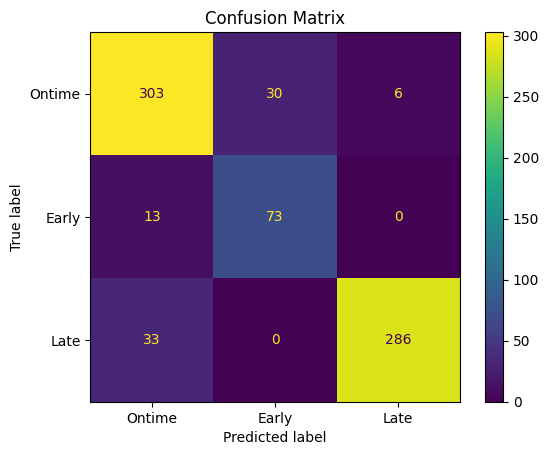

Scores    Values
0  Precision  0.852128
1     Recall  0.879731
2   Accuracy  0.889785
3         F1  0.863157

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       339
           2       0.71      0.85      0.77        86
           3       0.98      0.90      0.94       319

    accuracy                           0.89       744
   macro avg       0.85      0.88      0.86       744
weighted avg       0.90      0.89      0.89       744



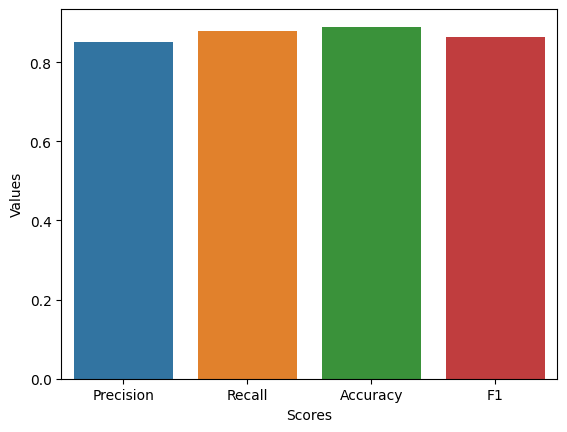

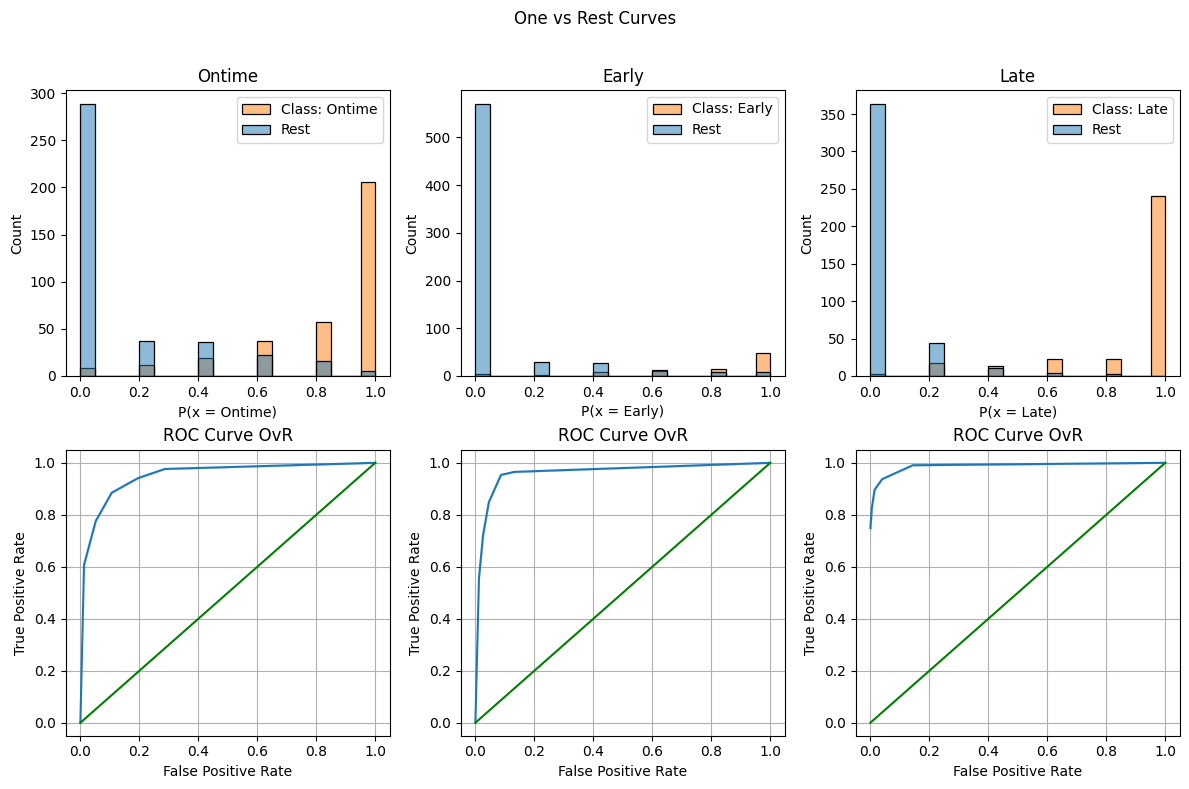

#### ROC AUC for each class

Ontime ROC AUC OvR: 0.9501
Early ROC AUC OvR: 0.9610
Late ROC AUC OvR: 0.9878
Average ROC AUC OvR: 0.9663


In [274]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [276]:
save_result('KNeighborsClassifier',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [278]:
result_list[0]

{'Model': 'KNeighborsClassifier',
 'Train Time': 0.48653078079223633,
 'Accuracy': 0.8897849462365591,
 'Best Params': {'model__n_neighbors': 5, 'model__weights': 'uniform'},
 'F1': 0.8631569795803674,
 'Recall': 0.87973141439159,
 'Precision': 0.8521282537596891}

#### Logistic Regression Grid Search Execution

In [281]:
# Pipeline with model, oversampling and scaling
lr_pipe = PipelineImb([
        ('oversampling', oversampling_method),
        ('stdscl', StandardScaler()),
        ('model', LogisticRegression())
    ])

lr_pipe

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()), ('model', LogisticRegression())])

In [283]:
# Run Gridsearch and get the best estimator
params = {'model__C': [0.01, 0.1, 1, 10],
          'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear', 'saga'], 
          'model__random_state':[42], 'model__max_iter': [100, 1000, 2500]}
grid = GridSearchCV(lr_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [285]:
lr_bestmodel = best_est

In [287]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

31.32427453994751

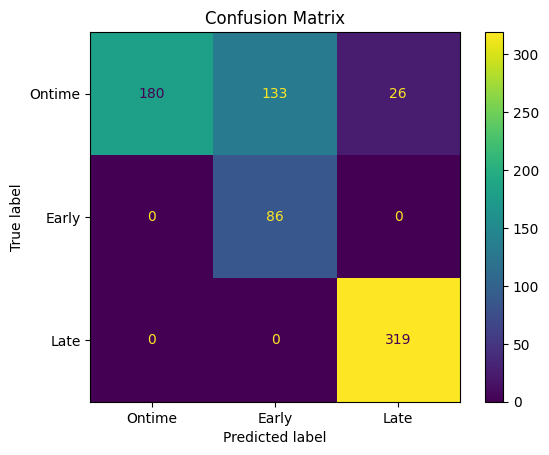

Scores    Values
0  Precision  0.772444
1     Recall  0.843658
2   Accuracy  0.786290
3         F1  0.739473

              precision    recall  f1-score   support

           1       1.00      0.53      0.69       339
           2       0.39      1.00      0.56        86
           3       0.92      1.00      0.96       319

    accuracy                           0.79       744
   macro avg       0.77      0.84      0.74       744
weighted avg       0.90      0.79      0.79       744



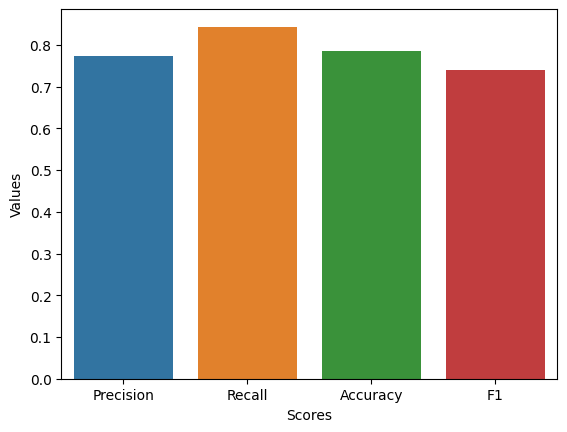

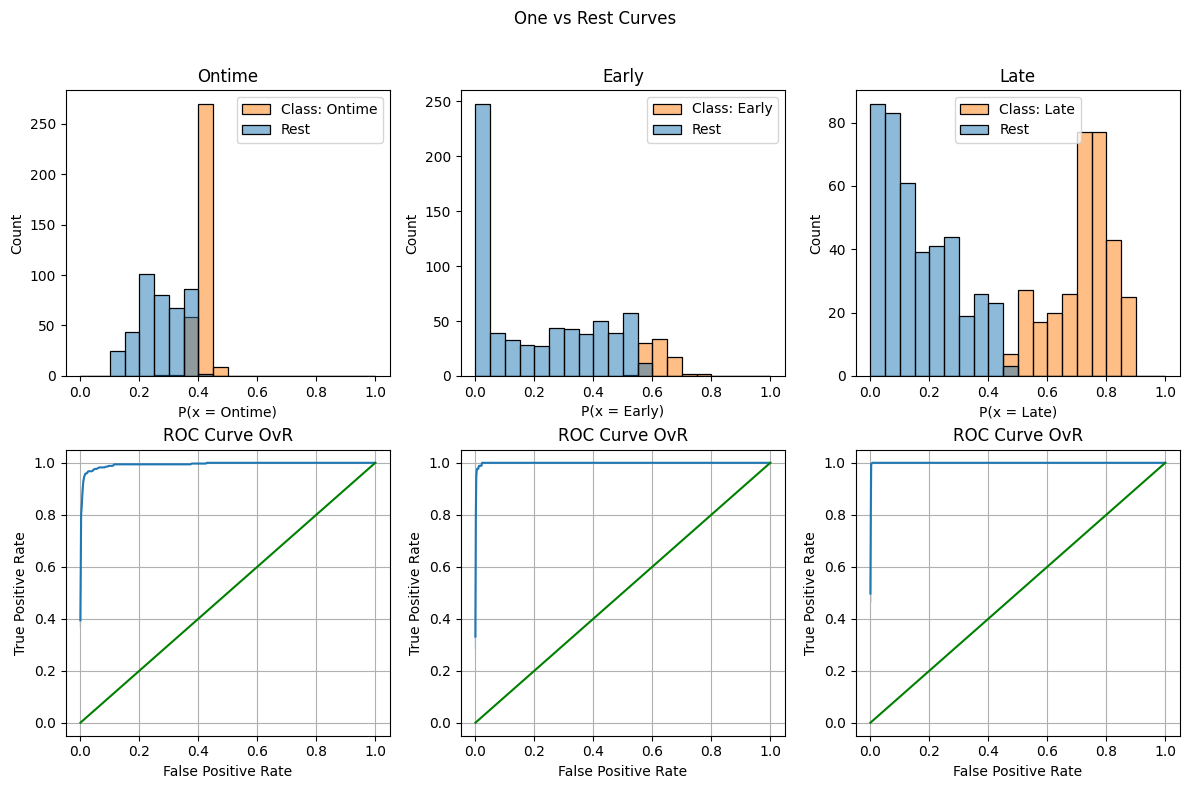

#### ROC AUC for each class

Ontime ROC AUC OvR: 0.9943
Early ROC AUC OvR: 0.9991
Late ROC AUC OvR: 1.0000
Average ROC AUC OvR: 0.9978


In [291]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [293]:
save_result('LogisticRegression',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [295]:
result_list[1]

{'Model': 'LogisticRegression',
 'Train Time': 31.32427453994751,
 'Accuracy': 0.7862903225806451,
 'Best Params': {'model__C': 0.01,
  'model__max_iter': 100,
  'model__penalty': 'l1',
  'model__random_state': 42,
  'model__solver': 'liblinear'},
 'F1': 0.7394731394068647,
 'Recall': 0.8436578171091446,
 'Precision': 0.772443915028787}

#### Decision Tree Grid Search Execution

In [298]:
# Pipeline with model, oversampling and scaling
dtree_pipe = PipelineImb([
        ('oversampling', oversampling_method),
        ('stdscl', StandardScaler()),
        ('model', DecisionTreeClassifier(random_state=42))
    ])

dtree_pipe

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=42))])

In [300]:
# Run Gridsearch and get the best estimator
params = {'model__max_depth': [1,2,3,4,5,6,7,8],
          'model__min_samples_split': [2,4,6,8],
          'model__criterion': ['gini', 'entropy'],
          'model__min_samples_leaf': [1,2,4,6]
         }

grid = GridSearchCV(dtree_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=1, random_state=42))])

In [302]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

8.08060908317566

In [304]:
dtree_bestmodel = best_est

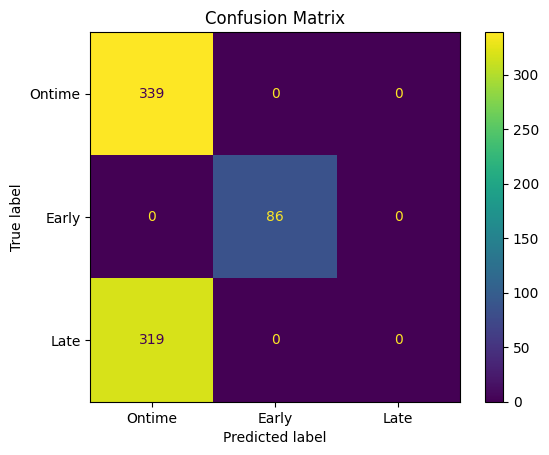

Scores    Values
0  Precision  0.505066
1     Recall  0.666667
2   Accuracy  0.571237
3         F1  0.560013

              precision    recall  f1-score   support

           1       0.52      1.00      0.68       339
           2       1.00      1.00      1.00        86
           3       0.00      0.00      0.00       319

    accuracy                           0.57       744
   macro avg       0.51      0.67      0.56       744
weighted avg       0.35      0.57      0.43       744



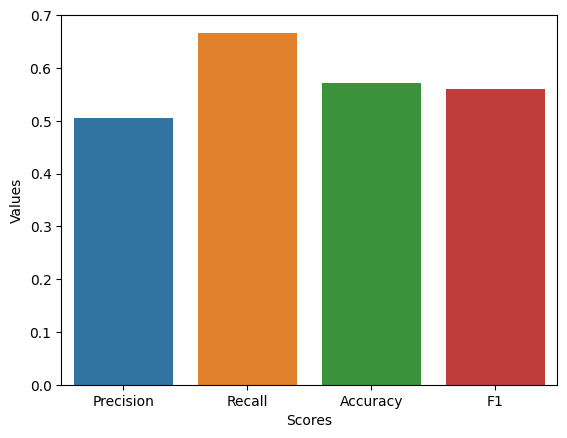

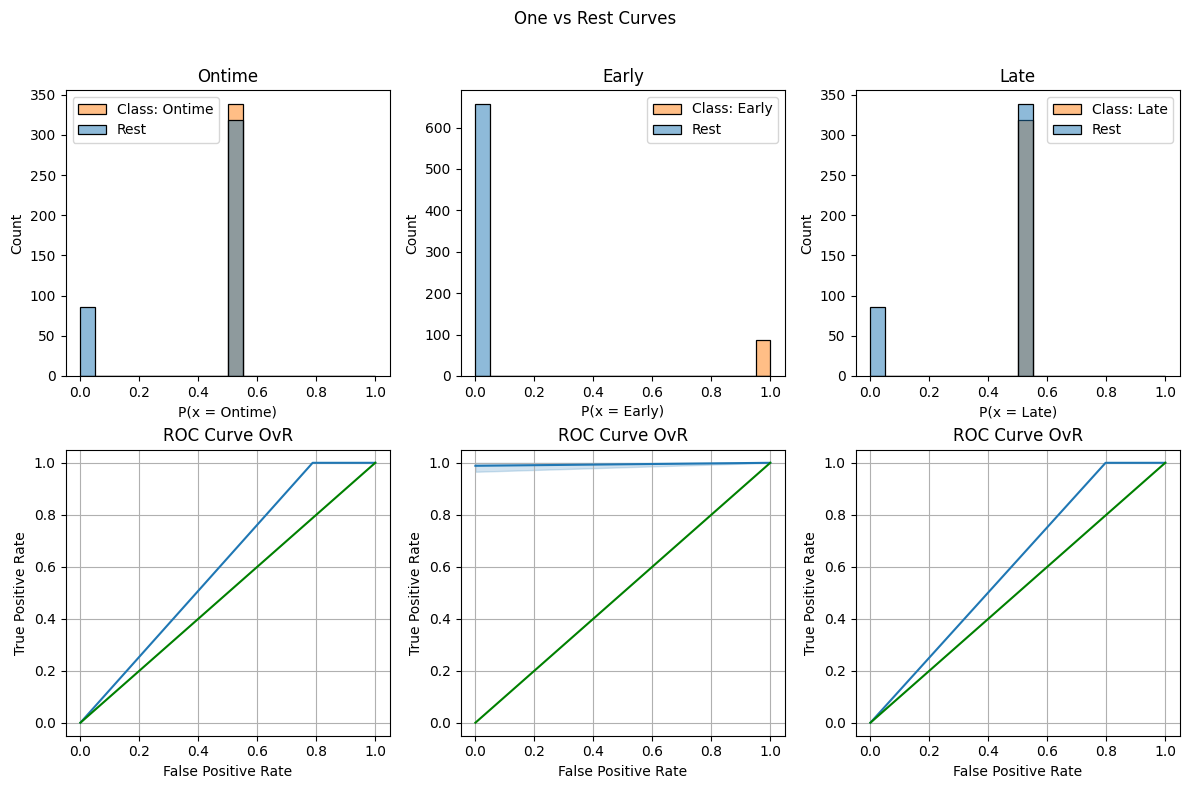

#### ROC AUC for each class

Ontime ROC AUC OvR: 0.6062
Early ROC AUC OvR: 1.0000
Late ROC AUC OvR: 0.6012
Average ROC AUC OvR: 0.7358


In [306]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [308]:
save_result('DecisionTreeClassifier',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [310]:
result_list[2]

{'Model': 'DecisionTreeClassifier',
 'Train Time': 8.08060908317566,
 'Accuracy': 0.571236559139785,
 'Best Params': {'model__criterion': 'gini',
  'model__max_depth': 1,
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 2},
 'F1': 0.5600133734536944,
 'Recall': 0.6666666666666666,
 'Precision': 0.5050658561296859}

#### SVM Grid Search Execution

In [313]:
# Pipeline with model, oversampling and scaling
svr_pipe = PipelineImb([
        ('oversampling', oversampling_method),
        ('stdscl', StandardScaler()),
        ('model', SVC())
    ])

svr_pipe

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()), ('model', SVC())])

In [315]:
# Run Gridsearch and get the best estimator
params = {'model__C': [0.1, 1, 1,5,10], 'model__kernel': ('linear', 'poly', 'rbf'),
          'model__degree' : [2,3,4,5], 'model__gamma': [0.01, 0.1], 'model__probability':[True]}
grid = GridSearchCV(svr_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_
best_est.fit(X_train, y_train)

Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                ('stdscl', StandardScaler()),
                ('model',
                 SVC(C=0.1, degree=2, gamma=0.01, kernel='linear',
                     probability=True))])

In [317]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

151.67864012718204

In [319]:
svm_bestmodel = best_est

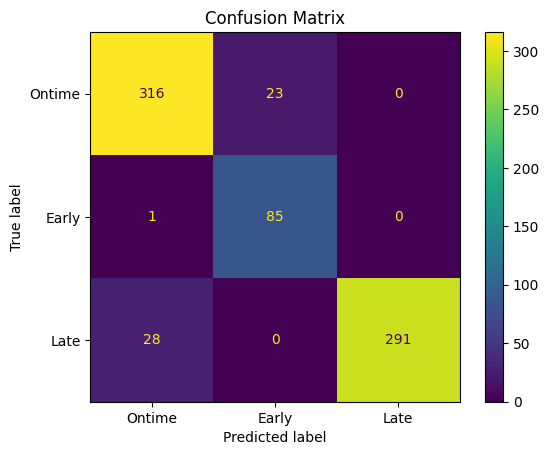

Scores    Values
0  Precision  0.900993
1     Recall  0.944250
2   Accuracy  0.930108
3         F1  0.918121

              precision    recall  f1-score   support

           1       0.92      0.93      0.92       339
           2       0.79      0.99      0.88        86
           3       1.00      0.91      0.95       319

    accuracy                           0.93       744
   macro avg       0.90      0.94      0.92       744
weighted avg       0.94      0.93      0.93       744



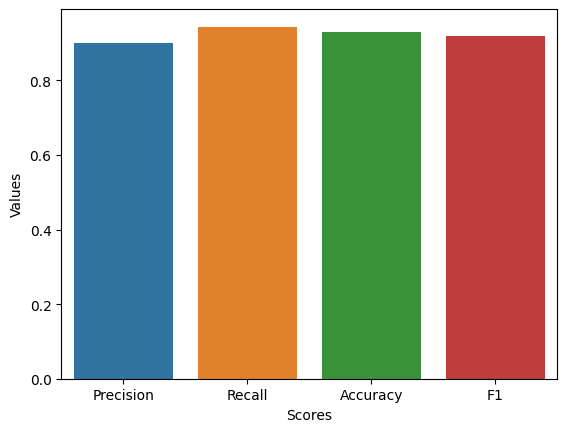

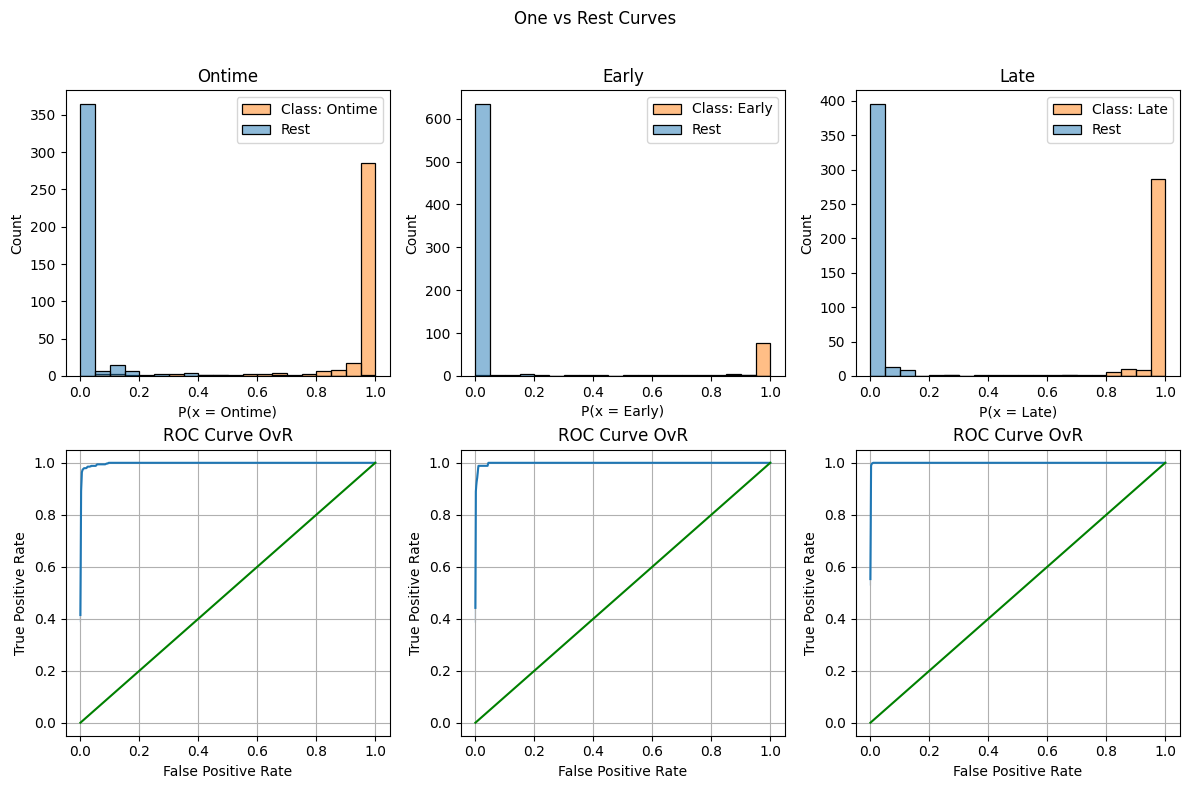

#### ROC AUC for each class

Ontime ROC AUC OvR: 0.9984
Early ROC AUC OvR: 0.9989
Late ROC AUC OvR: 0.9999
Average ROC AUC OvR: 0.9991


In [321]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [323]:
save_result('SVC',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [325]:
result_list[3]

{'Model': 'SVC',
 'Train Time': 151.67864012718204,
 'Accuracy': 0.9301075268817204,
 'Best Params': {'model__C': 0.1,
  'model__degree': 2,
  'model__gamma': 0.01,
  'model__kernel': 'linear',
  'model__probability': True},
 'F1': 0.9181212095455623,
 'Recall': 0.9442503968942644,
 'Precision': 0.9009930220075147}

#### Random Forest Classifier

In [328]:
# Get the Decision Tree best params, they will be used for next classifiers which use a decision tree as the 
# best model.
best_dtree_params = result_list[2]["Best Params"]

In [330]:
# Pipeline with model, oversampling and scaling
# Use the best decision tree params
rfr_pipe = PipelineImb([
        ('stdscl', StandardScaler()),
        ('oversampling', oversampling_method),
        ('model', RandomForestClassifier(
            random_state=42,
            criterion = best_dtree_params['model__criterion'],
            max_depth = best_dtree_params['model__max_depth'],
            min_samples_leaf = best_dtree_params['model__min_samples_leaf'],
            min_samples_split = best_dtree_params['model__min_samples_split'],
        ))
    ])

rfr_pipe

Pipeline(steps=[('stdscl', StandardScaler()),
                ('oversampling', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=1, random_state=42))])

In [332]:
# Grid search
params = {
          'model__n_estimators': [100, 150, 200, 300]
         }

grid = GridSearchCV(rfr_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_

In [334]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

2.2931711673736572

In [336]:
rforest_bestmodel = best_est

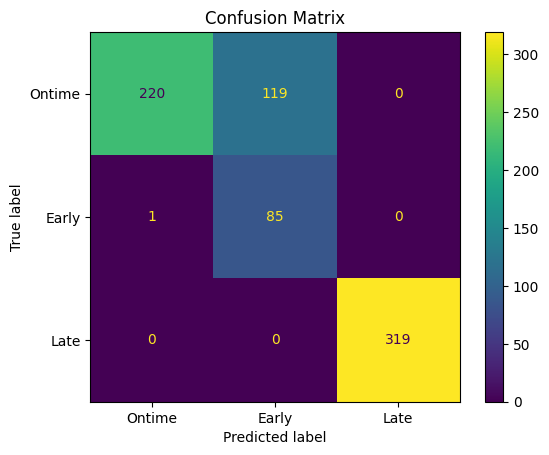

Scores    Values
0  Precision  0.804047
1     Recall  0.879113
2   Accuracy  0.838710
3         F1  0.790640

              precision    recall  f1-score   support

           1       1.00      0.65      0.79       339
           2       0.42      0.99      0.59        86
           3       1.00      1.00      1.00       319

    accuracy                           0.84       744
   macro avg       0.80      0.88      0.79       744
weighted avg       0.93      0.84      0.85       744



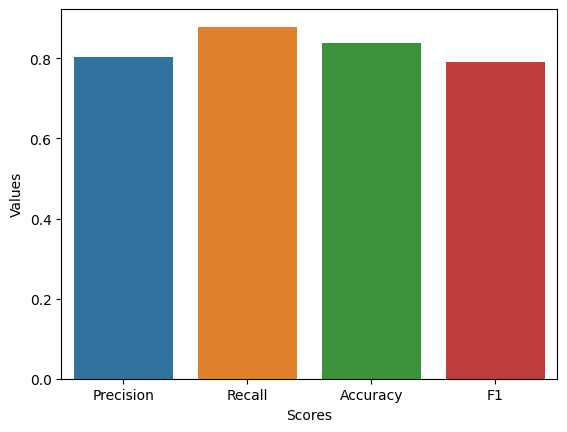

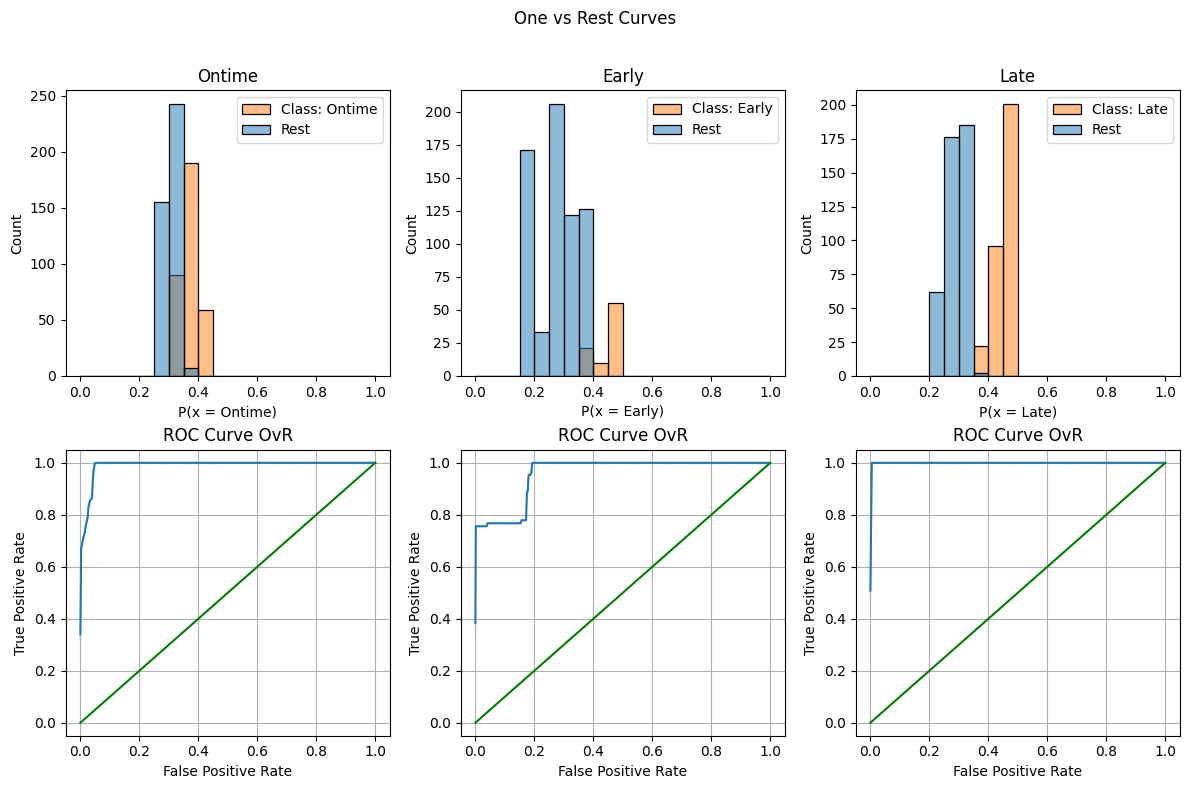

#### ROC AUC for each class

Ontime ROC AUC OvR: 0.9903
Early ROC AUC OvR: 0.9583
Late ROC AUC OvR: 1.0000
Average ROC AUC OvR: 0.9829


In [338]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [340]:
save_result('RandomForestClassifier',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [342]:
result_list[len(result_list)-1]

{'Model': 'RandomForestClassifier',
 'Train Time': 2.2931711673736572,
 'Accuracy': 0.8387096774193549,
 'Best Params': {'model__n_estimators': 100},
 'F1': 0.7906403940886699,
 'Recall': 0.8791132148818915,
 'Precision': 0.804047259929613}

#### AdaBoost Classifier

In [345]:
# Ada Boost Classifier Pipeline with the best decision tree params, standard scaler and oversampling
ada_pipe = PipelineImb([
        ('stdscl', StandardScaler()),
        ('oversampling', oversampling_method),
        ('model', AdaBoostClassifier(
            random_state=42, 
            estimator = DecisionTreeClassifier(
                criterion = best_dtree_params['model__criterion'],
                max_depth = best_dtree_params['model__max_depth'],
                min_samples_leaf = best_dtree_params['model__min_samples_leaf'],
                min_samples_split = best_dtree_params['model__min_samples_split'],
            )
        ))
    ])

ada_pipe

Pipeline(steps=[('stdscl', StandardScaler()),
                ('oversampling', SMOTE(random_state=42)),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    random_state=42))])

In [347]:
# Grid search
params = {
          'model__n_estimators': [100, 150, 200, 300]
         }

grid = GridSearchCV(ada_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_
adaboost_bestmodel = best_est

In [348]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

5.528594493865967

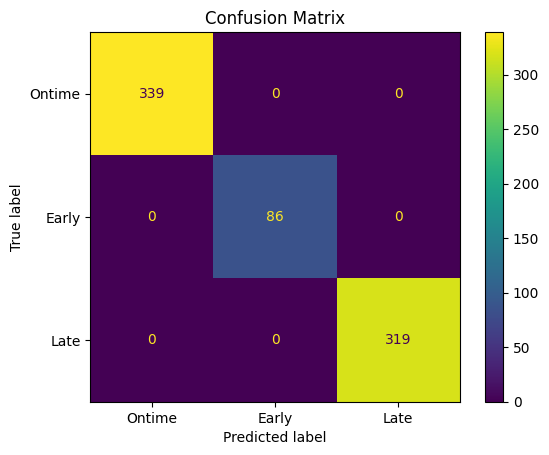

Scores  Values
0  Precision     1.0
1     Recall     1.0
2   Accuracy     1.0
3         F1     1.0

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       339
           2       1.00      1.00      1.00        86
           3       1.00      1.00      1.00       319

    accuracy                           1.00       744
   macro avg       1.00      1.00      1.00       744
weighted avg       1.00      1.00      1.00       744



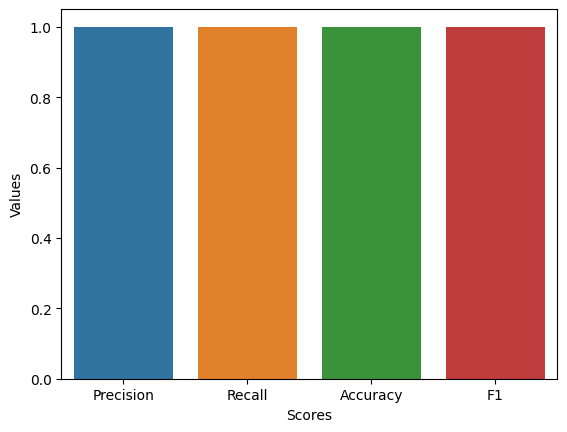

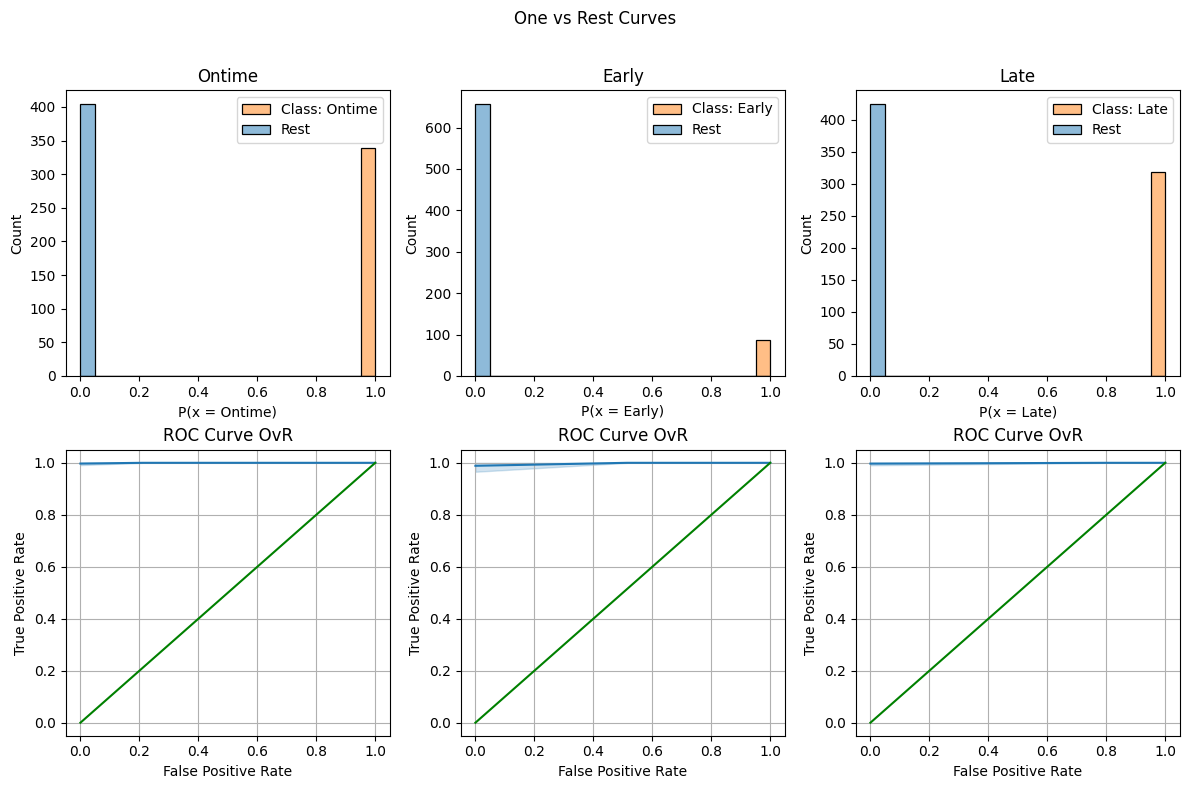

#### ROC AUC for each class

Ontime ROC AUC OvR: 1.0000
Early ROC AUC OvR: 1.0000
Late ROC AUC OvR: 1.0000
Average ROC AUC OvR: 1.0000


In [349]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [353]:
save_result('AdaBoostClassifier',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [355]:
result_list[len(result_list)-1]

{'Model': 'AdaBoostClassifier',
 'Train Time': 5.528594493865967,
 'Accuracy': 1.0,
 'Best Params': {'model__n_estimators': 100},
 'F1': 1.0,
 'Recall': 1.0,
 'Precision': 1.0}

#### Gradient Boosting Classifier

In [358]:
# Gradient Boosting Classifier Pipeline with the best decision tree params, standard scaler and oversampling
gbc_pipe = PipelineImb([
        ('stdscl', StandardScaler()),
        ('oversampling', oversampling_method),
        ('model', GradientBoostingClassifier(
            random_state=42, 
            max_depth = best_dtree_params['model__max_depth'],
            min_samples_leaf = best_dtree_params['model__min_samples_leaf'],
            min_samples_split = best_dtree_params['model__min_samples_split']     
        ))
    ])

gbc_pipe

Pipeline(steps=[('stdscl', StandardScaler()),
                ('oversampling', SMOTE(random_state=42)),
                ('model',
                 GradientBoostingClassifier(max_depth=1, random_state=42))])

In [360]:
# Grid search
params = {
          'model__n_estimators': [100, 150, 200, 300],
          'model__criterion': ['friedman_mse','squared_error'],
          'model__learning_rate': [0.1, 0.5, 1]
         }

grid = GridSearchCV(gbc_pipe, param_grid=params, scoring='f1').fit(X_train, y_train)
best_est = grid.best_estimator_
gdc_bestmodel = best_est

In [361]:
# Get the fit time from grid cvresults_
fit_time = get_training_time_from_grid(grid)
fit_time

35.250262498855584

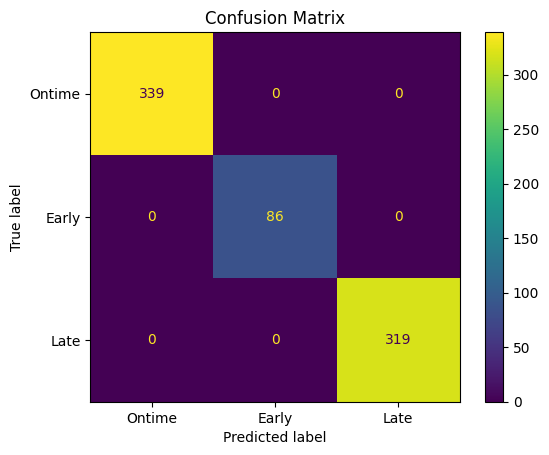

Scores  Values
0  Precision     1.0
1     Recall     1.0
2   Accuracy     1.0
3         F1     1.0

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       339
           2       1.00      1.00      1.00        86
           3       1.00      1.00      1.00       319

    accuracy                           1.00       744
   macro avg       1.00      1.00      1.00       744
weighted avg       1.00      1.00      1.00       744



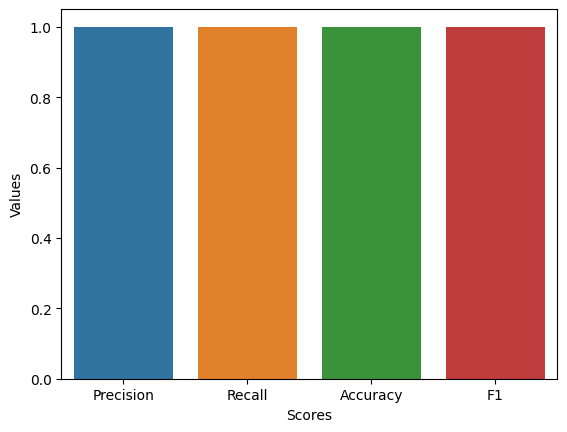

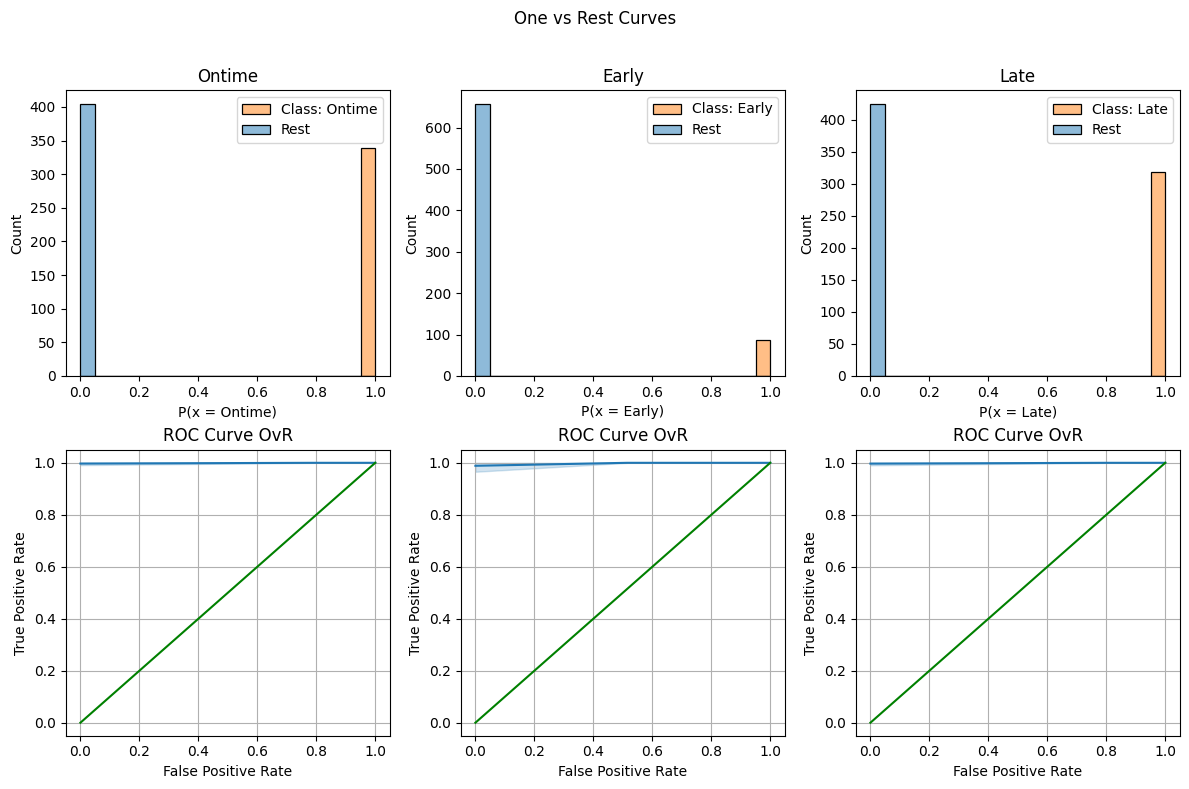

#### ROC AUC for each class

Ontime ROC AUC OvR: 1.0000
Early ROC AUC OvR: 1.0000
Late ROC AUC OvR: 1.0000
Average ROC AUC OvR: 1.0000


In [364]:
# Predict and score the best estimator performance
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)
getConfusionMatrix(y_test, y_test_pred, display_labels=['Ontime', 'Early', 'Late'])
precision, recall, accuracy, f1 = getScores(y_test, y_test_pred)
print(classification_report(y_test,y_test_pred))
get_ovr_curve(X_test, y_test, best_est)

In [366]:
save_result('GradientBoostingClassifier',fit_time, accuracy, grid.best_params_, f1, recall, precision)

In [368]:
result_list[len(result_list)-1]

{'Model': 'GradientBoostingClassifier',
 'Train Time': 35.250262498855584,
 'Accuracy': 1.0,
 'Best Params': {'model__criterion': 'friedman_mse',
  'model__learning_rate': 0.1,
  'model__n_estimators': 100},
 'F1': 1.0,
 'Recall': 1.0,
 'Precision': 1.0}

### Model Performance Summary

In [371]:
pd.set_option('display.max_colwidth', None)
result_df = pd.DataFrame(result_list).sort_values(by='F1', ascending=False).reset_index().set_index('Model').drop('index', axis=1)
styles = [dict(selector="th", props=[("text-align", "center")])]
result_df.style.set_table_styles(styles)


#### Models Performance Scores

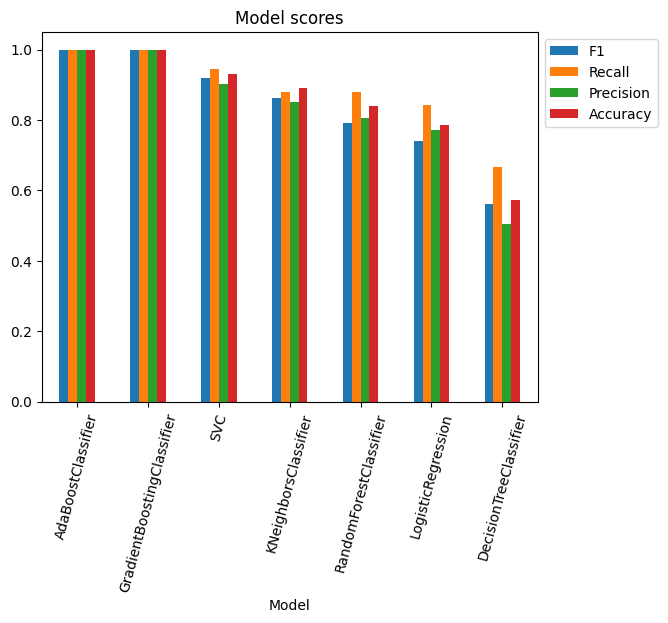

In [224]:
ax = result_df[["F1", "Recall", "Precision", "Accuracy"]].plot(kind='bar')
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=75)
plt.title("Model scores")
plt.show()

Based on the f1 score, we found that:
- AdaBoostClassifier and GradientBoostingClassifier are overfitted so they are not going to be used.
- SVC has the best score, followed by KNN which is very close behind.
- SVC performed well but it took at lot time in comparison to the others models
- KNN has a good score and it was really fast so we are going to use it as our final model.

### Feature importance

In [404]:
# Set the best model
final_best_model = knn_bestmodel
importances = permutation_importance(final_best_model, X_train, y_train, n_repeats = 10, random_state=42)


In [379]:
# Get the features
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
#display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
#display(importances_tr)
import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)


Importances
DifferencePrevBusIn     0.511161
TripDuration            0.036127
StopDuration            0.028328
PeakHour                0.018826
IsWeekday               0.017033
TripSpeedAvg            0.011833
TripDistance            0.006455

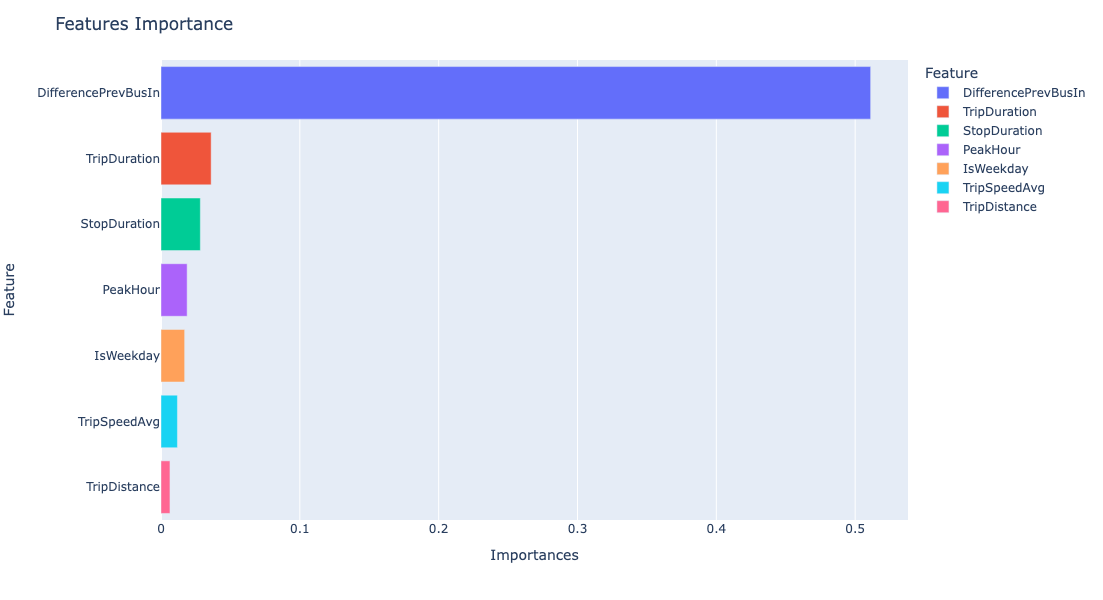

In [381]:
fig = px.bar(import_df.reset_index(), x="Importances", y = 'index', color='index', labels={'index' : 'Feature'})
fig.update_layout(
    autosize=False,
    width=750,
    height=600,
    title="Features Importance"
)
fig.show()

### Feature review
#### DifferencePrevBusIn
This feature has an important influence on the prediction as it contains the difference between the current arrival time and the previous one. As this value increases the status tends to be Late otherwie as it decreases to much the status will be Early. Late status means the travel time between stops could be affected by factor like the number of passengers, traffic and weather by ,identificating these factor the company can take decision about modify the bus frequency and design new routes. 
#### TripDuration
The time needed by the bus to complete a route loop is also related to the number of passengers, traffic and weather, also there can be route detours, as the TripDuration increases the more Late statuses will be detected.
#### StopDuration
This duration can be related with the number of passengers which were boarding and alighting the bus, unfortunately we were not able to include that feature in the dataset for the scope of this capstone. 
#### PeakHour
The peak hour has an important influence because the city will have more traffic on those hours, more traffic and more people using the buses causing the travel time increases between stops so more Late statuses. 

### Findings
1. The results show us that with the help of Machine Learning techniques and the Exploratory Data Analysis it's possible to predict Bus Arrival Status.
2. According to the performance metrics we used the best model for the On Time Status prediction is KNN, it got a good score and due to the low training time it will be more suitable for implemetation that other models.
3. To meet the expected bus frequency (each 15 minute a bus visiting a stop), the company needs to monitor periodically the bus performance by checking each stop arrival status metric along with Time difference between Stop Visits, Trip Duration. Stop Duration and the Peak Hours.

### Next Steps and Recommendations
1. Include new features to datatset to help with the predictions:
    - Passenger Counter: the number of passengers which board and alight the bus could have an impact on the travel times so we recommend to the Public Transportation company give access to that info so we can extract it and include within the dataset.
    - Weather: the weather conditions also impact on the travel times, we recommend the weather be tracked by integrating weather API with Public Transportations System then we can include in the dataset.
2. Create new datasets for Stops from different Routes, that new data will help for tuning the features and Machine Learning Models.

### References
1. About imbalanced datasets and the oversampling techniques:
    - https://machinelearningmastery.com/multi-class-imbalanced-classification/
    - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
    - https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
2. About the ROC Curve for multiclass:
    - https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb  
3. About the Public Transportations Bus frequency
    - https://www.transitwiki.org/TransitWiki/index.php/Headway 
